In [1]:
#Attribution: https://github.com/indeedlabs/indeed-python
from indeed import IndeedClient
import re
client = IndeedClient(publisher ="9124561496937265")
import time
import sqlite3
import glob
from bs4 import BeautifulSoup # For HTML parsing
import urllib # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [11]:
class Indeed_JobScrap():
    
    def __init__(self, db_fname, overwrite_db, job_requirements_ls):
        self.overwrite_db = overwrite_db
        self.db_fname = db_fname
        self.job_requirements_ls = job_requirements_ls
        self.job_items = ["jobtitle", "date", "company", "country", "state", 
                          "longitude", "latitude"]
        self.tracker = [] #tracker how many consecutives job_response ar null
        self.thres = 3 #if 3 consecutives job detail request empty, stop 
        self.listing = {}
        self.table_name = "jobs"
        self.dbname = "job_listings"
        self.url = 'https://www.indeed.com/viewjob?jk='
        self.other_tables = ['degrees', 'progskills', 'qualifications', 'expertise']
        self.sdc_expressions = ['autonomous vehicles', 'autonomous cars', 'self-driving cars', 
                                'self-driving car', 'self driving cars', 'self driving car',
                                'autonomous vehicles']
    
    def connect_db(self):
        sql_files = glob.glob('*.db')
        if (self.db_fname in sql_files) or (overwrite_db == False):
            self.conn = sqlite3.connect(self.db_fname)
            self.c = self.conn.cursor()
        else:
            #open connection to local file
            self.conn = sqlite3.connect(self.db_fname)
            self.c = self.conn.cursor()
            # Create table
            try:
                self.c.execute("CREATE TABLE {} (jobkey, jobtitle, employer, date, country, state, longitude, latitude)".format(self.table_name))
                print('Created Table: {} in database {}'.format(self.table_name, self.dbname) )
                self.conn.commit()
            except:
                print('Unable to create table {}'.format(self.table_name))
            for this_table in self.other_tables:
                try:
                    col_name = this_table + '_req'
                    self.c.execute("CREATE TABLE {} (jobkey, {})".format(this_table, col_name))
                    print('Created Table: {} in database {}'.format(this_table, self.dbname) )
                    # Save (commit) the changes
                    self.conn.commit()
                except:
                        print('Unable to create table {}'.format(this_table))
                
                
                
                
    def save2db(self, job_entry):
        '''
        Save job_entry data to database: 
        jobkey, jobtitle, employer, data, country, state, longitude, latitude,
        degrees, qualifications, expertise, progskills
        '''
        #check if job in db
        sql_select = "SELECT {}.jobkey FROM {} WHERE {}.jobkey = '{}';".format(self.table_name, self.table_name, self.table_name, job_entry['jobkey'])
        flag_jobindb = False
        flag_error = False
        try:
            self.c.execute(sql_select)
            result = self.c.fetchall()
            if len(result) != 0:
                flag_jobindb = True
        except:
            # Insert a row of data
            print('Unable to execute SQL query: SELECT')
            flag_error = True
        print('job entry already recorded: {}'.format(flag_jobindb))        
        if flag_jobindb == False:
            #add job entry to jobs table
            sql_insert = "INSERT INTO {} VALUES ('{}', '{}', '{}', '{}', '{}', '{}', '{}', '{}');".format(self.table_name, 
            job_entry['jobkey'], job_entry['jobtitle'], job_entry['company'], job_entry['date'], 
            job_entry['country'], job_entry['state'], job_entry['longitude'], job_entry['latitude'])
            try:
                self.c.execute(sql_insert)
                self.conn.commit()
                print('Job entry saved in DB')
            except:
                print('Unable to save job entry in {}'.format(self.table_name))
            
            #add entry to other_tables
            for this_table in self.other_tables:
                if len(job_entry[this_table]) != 0:
                    for item in job_entry[this_table]:
                        sql_insert = "INSERT INTO {} VALUES ('{}','{}');".format(this_table, job_entry['jobkey'], item)
                        try:
                            self.c.execute(sql_insert)
                            self.conn.commit()
                        except:
                            print('Unable to save item {} in {}'.format(item, this_table))
        else:
            #update database
            sql_update = "UPDATE {} SET {}='{}', {}='{}', {}='{}', {}='{}', {}='{}', {}='{}', {}='{}' WHERE {}.jobkey={};".format(self.table_name, 
            'job_title', job_entry['jobtitle'], 'employer', job_entry['company'], 'date', job_entry['date'], 
            'country', job_entry['country'], 'state', job_entry['state'], 'longitude', 
            job_entry['longitude'], 'latitude', job_entry['latitude'], self.table_name, job_entry['jobkey'] )
            try:
                self.c.execute(sql_update)
                self.conn.commit()
                print('Job entry saved in DB')
            except:
                print('Unable to save job entry in {}'.format(self.table_name))
            
            #add/update entry to other_tables
                            

    def sanitize_text(self, text):
        try:
            text = text.decode('unicode_escape').encode('ascii', 'ignore') 
        except:
            pass

        #Remove special characters
        special_chars = "!@#$%^&*()[]{};:,./<>?\|`~=_"
        for special_char in special_chars:
            clean_text = text.replace(special_char, " ")
        #remove newline
        clean_text = " ".join(clean_text.split())
        clean_text = re.sub("[^a-zA-Z+2]"," ", clean_text)
        return clean_text
    
    
    
    def get_jobsListing(self, keywords, start, limit):
        query = ""
        if len(keywords) > 0:
            #build query
            for item in keywords:
                query = query +"+"+item
        
            params = {
                      'q' : query,
                      # 'l' : "austin",
                      'start': start,
                      'limit': limit, #maximum nbr of results returned
                      'userip' : "1.2.3.4",
                      'useragent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2)"
                     }

            return client.search(**params)
        else:
            return []                                                                                                            


                                                                                                      
                                                                                                                        
    def snif_jobDescription(self, jobkey):
        this_url = self.url+str(jobkey)
        flag_error = False
        try:
            site = urllib.request.urlopen(this_url).read() # Connect to the job posting
            soup_obj = BeautifulSoup(site, "lxml")
        except:
            print('page not found')
            flag_error = True
        
        if flag_error == False:
            # search for all <span tag
            spans = soup_obj.find_all('span', attrs={'id':"job_summary"})
            if len(spans) == 1:
                #convert soup object to text
                text = spans[0].get_text()
                #Cleaning text
                clean_text = self.sanitize_text(text)
                if ( any(x in clean_text for x in self.sdc_expressions)): #if text contains any of the sdc_expressions        
                    text_split = clean_text.split()
                    return text_split
                else:
                    return []
            else:
                return []


    def extract_jobRequirements(self, jobkey):
        #get text job description
        job_description_txt = self.snif_jobDescription(jobkey)
        #save job requirements in job_req
        job_req = {}
        #Initialize
        for i in self.job_requirements_ls:
            job_req[i] = []

        #better to scroll thru text once
        for idx, word in enumerate(job_description_txt):
            w_lower = word.lower()
            
            for key in self.job_requirements_ls:
                if key == 'expertise' or key == 'qualifications':
                    if w_lower in self.job_requirements_ls[key]:
                        if len(self.job_requirements_ls[key][w_lower])==0:
                            #the word has no child in list of job req  (like 'cs':[]) 
                            if len(job_req[key])==0:
                                job_req[key] = [w_lower]
                            elif w_lower not in job_req[key]:
                                job_req[key].append(w_lower)
                        else:
                            #check the word is not the last of the job_description (otherwise next_word does not exist)
                            if idx < len(job_description_txt)-1:
                                next_word = job_description_txt[idx+1].lower()
                                #check if expression=word+next_word is in our list of job_requirements of that key
                                if next_word in self.job_requirements_ls[key][w_lower]:
                                    expression = w_lower+" "+next_word
                                    if len(job_req[key])==0:
                                        job_req[key] = [expression]
                                    elif expression not in job_req[key]:
                                        job_req[key].append(expression)
                                
                else:
                    if w_lower in self.job_requirements_ls[key]:
                        if len(job_req[key])==0:
                            job_req[key] = [w_lower]
                        elif w_lower not in job_req[key]:
                            job_req[key].append(w_lower)
        
        return job_req

                            
    def record(self, keywords, start, limit):
        while len(self.tracker) < self.thres:
            #get more responses (pagination)
            query_response = self.get_jobsListing(keywords, start, limit)
            n_entry = 0
            print(start)
            for job_entry in query_response['results']:
                job_details = {}
                n_entry += 1
                print('********* Entry # {}'.format(n_entry))
                jobkey = job_entry['jobkey']
                job_details['jobkey'] = jobkey
                #Make a query on this jobkey
                job_entry_response = client.jobs(jobkeys = (jobkey, ))
                if len(job_entry_response['results']) > 0:
                    #reset tracker
                    self.tracker = []
                    job_entry_response = job_entry_response['results'][0]
                    ##save job specs (employer, title etc...)  ########
                    for job_item in self.job_items:
                        if job_item in job_entry_response:
                            job_details[job_item] = job_entry_response[job_item]
                        else:
                            job_details[job_item] = ""
                    
                    #extract job requirements from job description
                    job_req = self.extract_jobRequirements(jobkey)
                    job_specs = {**job_details, **job_req}
                    print(job_specs)
                    self.save2db(job_specs)       
                    time.sleep(1)
                    print('Jobkey {}'.format(jobkey))
                    print()

                else:
                    self.tracker.append(1)
            
            #check consistency n_entry and limit
            start = start + limit

                
        

In [38]:
degrees_ls = ['phd', 'ms', 'bsc', 'mba', 'master', 'masters', 'bachelors', 'bachelor', 'ba', 'bs']
qualifications_ls = {'cs':[], 'ce':[], 'ee':[], 'physics':[], 'electrical': ['engineering'], 'computer': ['science'],
                     'mechanical': ['engineering'], 'industrial': ['engineering']}
expertise_ls = {'machine': ['learning'], 'Deep': ['Learning'], 'computer': ['architecture'], 'Algorithms':[], 
                'GPU': ['computing'], 'parallel': ['programming'], 'Computer': ['Vision'], 
               'predictive': ['analytics'], 'vehicle':['design', 'development', 'regulations'],
               'autonomous':['vehicles'], 'robotics':[], 'radar':[], 'kinematics':[]}
progskills_ls = ['c++', 'c', 'c#', 'python', 'opencv', 'matlab', 'php', 'java', 'ruby', 'ros', 'tensorflow', 'keras']

job_requirements_ls = {'degrees': degrees_ls, 'qualifications': qualifications_ls, 'expertise': expertise_ls, 'progskills': progskills_ls}

#keywords = ['self-driving car']
#keywords = ['self-driving', 'car']
keywords = ['autonomous', 'cars']
#keywords = ['autonomous vehicles']
#keywords = ['autonomous cars']
#keywords = ['autonomous-cars']
start = 0
limit = 25
db_fname = 'indeed.db'
overwrite_db = True

jobsScrap = Indeed_JobScrap(db_fname, overwrite_db, job_requirements_ls)
#connect to database
jobsScrap.connect_db()

#
jobsScrap.record(keywords, start, limit)

0
********* Entry # 1
{'company': 'NXP Semiconductors', 'qualifications': ['electrical engineering'], 'country': 'US', 'degrees': ['bachelor', 'master'], 'date': 'Tue, 09 May 2017 20:04:19 GMT', 'longitude': -111.89566, 'state': 'AZ', 'progskills': [], 'jobkey': 'aaff084c53e83916', 'latitude': 33.34243, 'expertise': [], 'jobtitle': 'Systems & Applications Engineer'}
job entry already recorded: False
Job entry saved in DB
Jobkey aaff084c53e83916

********* Entry # 2
{'company': 'NXP Semiconductors', 'qualifications': ['computer science'], 'country': 'US', 'degrees': ['masters'], 'date': 'Thu, 04 May 2017 19:47:30 GMT', 'longitude': -121.925446, 'state': 'CA', 'progskills': ['c', 'c++', 'matlab'], 'jobkey': 'd5a0a660fbdd7661', 'latitude': 37.397102, 'expertise': ['radar', 'autonomous vehicles', 'parallel programming'], 'jobtitle': 'Systems Engineer ADAS RADAR'}
job entry already recorded: False
Job entry saved in DB
Jobkey d5a0a660fbdd7661

********* Entry # 3
{'company': 'CivilMaps', 'q

TypeError: 'NoneType' object is not iterable

In [ ]:
conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer

#k = [19e116b3b8b9142d, c8acfe28f5b7c2a5, 141de5c6bb03a6f7, b93cb63a881d1962, 0af5d1b6f3087803, 34818bd8f9c2fb24,
#       37ed6d5935e4b254, fb174186f27a53e8, 59468e265a77a81c, 634e159a2a6d0a87, 7a8b66aea2d4c851, d2f8ca044e51e65a, 
#        e0071062ac7070b9, e94f6e213ea5160b]

sql_manager = "SELECT jobkey FROM jobs WHERE jobkey='5147236854f820cc';"
c.execute(sql_manager)
result = c.fetchall()
print(len(result))
for jk in result:
    jk = jk[0]
    try:
        sql_delete = "DELETE FROM jobs WHERE jobkey='{}';".format(jk)
        c.execute(sql_delete)
        conn.commit()
    except:
        print('could not delete {} from table: jobs')

    try:
        sql_delete = "DELETE FROM degrees WHERE jobkey='{}';".format(jk)
        c.execute(sql_delete)
        conn.commit()
    except:
        print('could not delete {} from table: degrees')    
    try:
        sql_delete = "DELETE FROM expertise WHERE jobkey='{}';".format(jk)
        c.execute(sql_delete)
        conn.commit()
    except:
        print('could not delete {} from table: expertise')
    try:
        sql_delete = "DELETE FROM progskills WHERE jobkey='{}';".format(jk)
        c.execute(sql_delete)
        conn.commit()
    except:
        print('could not delete {} from table: progskills')
    try:
        sql_delete = "DELETE FROM qualifications WHERE jobkey='{}';".format(jk)
        c.execute(sql_delete)
        conn.commit()
    except:
        print('could not delete {} from table: qualifications')
c.execute(sql_manager)
result = c.fetchall()

164


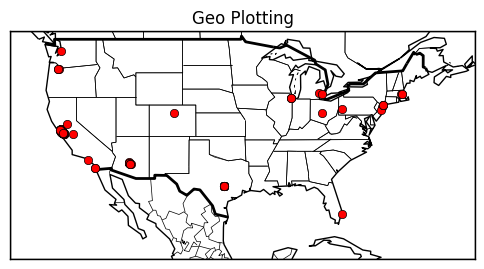

In [39]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer
sql_manager = "SELECT * FROM jobs;"
c.execute(sql_manager)
result = c.fetchall()
print(len(result))
data_pts = []        
for entry in result:
    data_pts.append([entry[6], entry[7]])

def mapTut(pts):

    m = Basemap(projection='mill',llcrnrlat=20,urcrnrlat=50,\
                llcrnrlon=-130,urcrnrlon=-60,resolution='c')
    m.bluemarble()
    m.drawcoastlines()
    m.drawcountries(linewidth=2)
    m.drawstates()
    #m.fillcontinents(color='#04BAE3',lake_color='#FFFFFF')
    m.drawmapboundary(fill_color='#FFFFFF')

    for point in pts:
        if len(point[0] ) > 0:
            lat, lon = float(point[1]), float(point[0])
            x,y = m(lon,lat)
            m.plot(x,y, 'ro')
   
    # Houston, Texas


    
    plt.title("Geo Plotting")
    plt.show()


mapTut(data_pts)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

ax = plt.gca() # get current axes instance

# get Texas and draw the filled polygon
seg = map.states[state_names.index('Texas')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)

plt.show()